## **Graficando resultados en Google Earth Engine**

En este cuaderno se va a aprender como generar gráficas de series temporales de índices de vegetacón generados a partir de una colección de imágenes.

### **1. Preparación del entorno de trabajo**

#### **1.1 Identificación en servicios Google**

Primero montamos nuestra unidad en **Google Drive**

In [1]:
from google.colab import auth, drive
auth.authenticate_user()

# Montamos la unidad de trabajo de nuestro drive
drive.mount('/content/drive/')

Mounted at /content/drive/


En segundo lugar nos identificamos en el servicio **Google Earth Engine**

In [2]:
import ee

ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=rZp3EpoJ5YCAGYsF_ZUteZS0niBQDGHBF9PhKyxyC1M&tc=HPymvjjdW0a5K-8OLEiA8V5mB5kzFtC6Va8mujkePcg&cc=_QNo_zwAuKCxJOOrFKYw6UUahZG5QCYK-vqMQTAgkSk

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AVHEtk7s0VyoGU8oWVdvGPHSYJKuNQMsPwy8UoNNCR2OqAL6fl-ypn96P_E

Successfully saved authorization token.


#### **1.2 Instalación de bibliotecas**
Se procede ahora a instalar un conjunto de librerías necesarias para representar las gráficas que deseamos generar.

In [3]:
# Permite cargar shapefiles y convertirlos en una featureCollectionLoad 
!pip install geetools
!pip install fastkml
!pip install pycrs
!pip install geemap

# Permite mostrar series como las vemos en Earth Engine Code Editor 
!pip install ipygee

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 KB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 KB 5.8 MB/s eta 0:00:00
  Created wheel for geetools: filename=geetools-0.6.14-py3-none-any.whl size=92107 sha256=a4e1051f6743730d7e25c2ce1e4f6db0c57a6561e262c06ee18887afb8d62900
  Stored in directory: /root/.cache/pip/wheels/20/4c/bf/0228d788d820ac3cf05cbaa753965eb6396b5d3fe11ed912e5
Successfully built geetools
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pygeoif: filename=pygeoif-0.7-py3-none-any.whl size=19015 sha256=1a68f2f7f4bc5a4aa1f2c42f31ad2516c1e59fb59a60976f85af17c447a8c572
  Stored in directory: /root/.cache/pip/

#### **1.3 Funciones necesarias**

###### **1.3.1 Función para calcular NDVI de una colección de imágenes**

La siguiente función calcula el NDVI de una colección de imágenes Sentinel 2![texto alternativo](https://)



In [4]:
def NDVI(entrada):
  ndvi = entrada.addBands(entrada.normalizedDifference(['B8','B4']).rename('NDVI'))
  return (ndvi)

La siguiente función aplica la máscara de nubes a una escena Sentinel-2

In [5]:
def ESAcloudMask(img):
    """
    European Space Agency (ESA) clouds from 'QA60', i.e. Quality Assessment band at 60m
    """
    qa = img.select('QA60')
    # bits 10 and 11 son nubes y cirros 
    cloudBitMask = int(2**10)
    cirrusBitMask = int(2**11)
    # Si 0 indicates condiciones claras.
    clear = qa.bitwiseAnd(cloudBitMask).eq(0).And(\
           qa.bitwiseAnd(cirrusBitMask).eq(0))
    
    # Nubes no estan claras
    cloud = clear.Not().rename(['ESA_clouds'])

    # Devuelve la banda de máscara de nubes.
    #return img.addBands(cloud)
    return img.updateMask(clear)

### **2. Pintar evolución temporal de una banda a lo largo del tiempo**

El siguiente script representa en una gráfica la evolución temporal media del índice NDVI sobre un conjunto de parcelas desde el 1 de Septiembre de 2016 1 de Marzo de 2021.

No se ha tenido en cuenta hacer un filtrado por el porcentaje de nubes presente en la escena.

Para generar la gráfica se ha empleado **chart.Image.series**, la cual necesita como parámetros de entrada:
* `imageCollection`: Colección de imágenes que contiene la banda a graficar.
* `bands`: Identificador de la banda a representar.
* `region`: eeFeatureCollection con las geometrías que se usaran para extraer la información de la banda de interés de cada una de las imagenes de la colección.
*  `scale`: Escala a la que extraer la información.

En el código, la gráfica queda almacenada en la variable denominada `gráfico`. Para pintarla se usará la libreía **matplotlib**, siendo necesario convertir la variable gráfico a un dataframe. En este dataframe tendremos una columna y tantas filas como escenas tenga la colección de imágenes, cada una con el valor de la banda de interés.

Una vez ejecutado el código analizar el comportamiento de la gráfica.

Numero de imágenes:  84


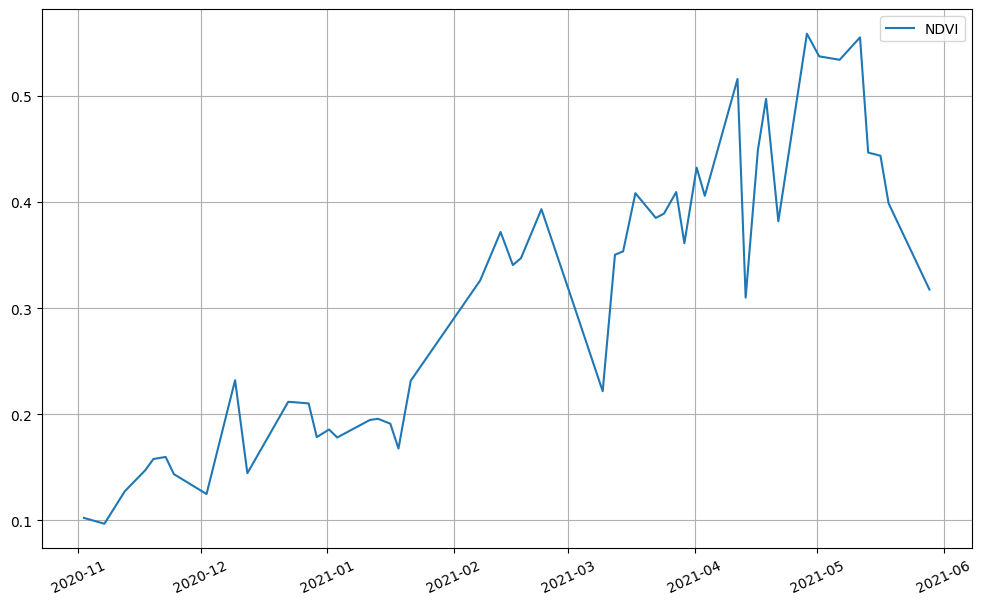

In [8]:
import os
import time
import math
import datetime
import geemap
import matplotlib.pyplot as plt
import matplotlib.dates as dt
from datetime import datetime as dateTim


from geetools import batch

# Show time series like earth engine
from ipygee import *
import json

#Leemos un shapeFile alojado en nuetro espacio en Google Drive
path_file = os.path.join('/content/drive/MyDrive/Colab Notebooks/HIBA/Cuadernos Colab/4 - Graficando resultados/datos/parcelas_grafico.shp')
tabla = geemap.shp_to_ee(path_file)

#Definimos las fechas de inicio y fin de la colección
start_date='2020-11-01'
end_date='2021-06-01'

#Creamos una colección de imágenes
coleccion = ee.ImageCollection('COPERNICUS/S2_SR').filterBounds(tabla)\
          .filterDate(start_date, end_date)

#Calculamos el índice NDVI a cada una de las imágenes de la colección
coleccion=coleccion.map(NDVI)

coleccion_sin_nubes=coleccion.map(ESAcloudMask)

print ("Numero de imágenes: ",coleccion.size().getInfo())

escala=10
bandas = ['NDVI']
grafico=chart.Image.series(**{
      'imageCollection': coleccion_sin_nubes,
      'region': tabla,
      'scale': escala,
      'bands': bandas
  })


formatter = dt.DateFormatter('%Y-%m-%d')  # Specify the format - %b gives us Jan, Feb...
locator = dt.MonthLocator()  # every month

df=grafico.dataframe

dates = df.index.values
indexes = df.columns
index_count = 0
index_total = len(indexes)

plt.figure(figsize=(12,7))
for i in range(index_total):
  index = indexes[i]
  data=df[index]
  plt.plot(dates,data,label=index)
  plt.xticks(rotation=25)
  plt.grid()
  plt.legend()


### **3. Pintar evolución temporal de una banda para un conjunto de geometrías**

El siguiente script se estudia como representar en una gráfica la evolución temporal de un estadístico de una banda dentro de una colección de imágenes, individualizando esta evlución para cada una de las *eeFeatures* de la *eeFeatureCollection*. 

En el script presentado inicialmente se ha contemplado una ventana temporal desde el 1 de Septiembre de 2016 al 1 de Marzo de 2021. Igual que en el caso anterior no se ha tenido en cuenta hacer un filtrado por el porcentaje de nubes presente en la escena.

Para generar la gráfica se emplea **chart.Image.seriesByRegion**, la cual necesita como parámetros de entrada:
* `imageCollection`: Colección de imágenes que contiene la banda a graficar.
* `band`: Identificador de la banda a representar.
* `region`: eeFeatureCollection con las geometrías que se usaran para extraer la información de la banda de interés de cada una de las imagenes de la colección.
*  `scale`: Escala a la que extraer la información.
* `reducer`: Se define que estadístico se desea representar: media, máximo, mínimo, etc.

Como antes,  la gráfica queda almacenada en una variable, que se ha denominada `gráfico`. Para pintarla se usará la libreía **matplotlib**, siendo necesario convertir la variable gráfico a un dataframe. En este dataframe tendremos una columna y tantas filas como escenas tenga la colección de imágenes, cada una con el valor de la banda de interés.


En el script se representa la evolución temporal de la media de NDVI de cada una del *eeFeature* de la colección.

Una vez ejecutado el código analizar el comportamiento de la gráfica.

Numero de imágenes:  121


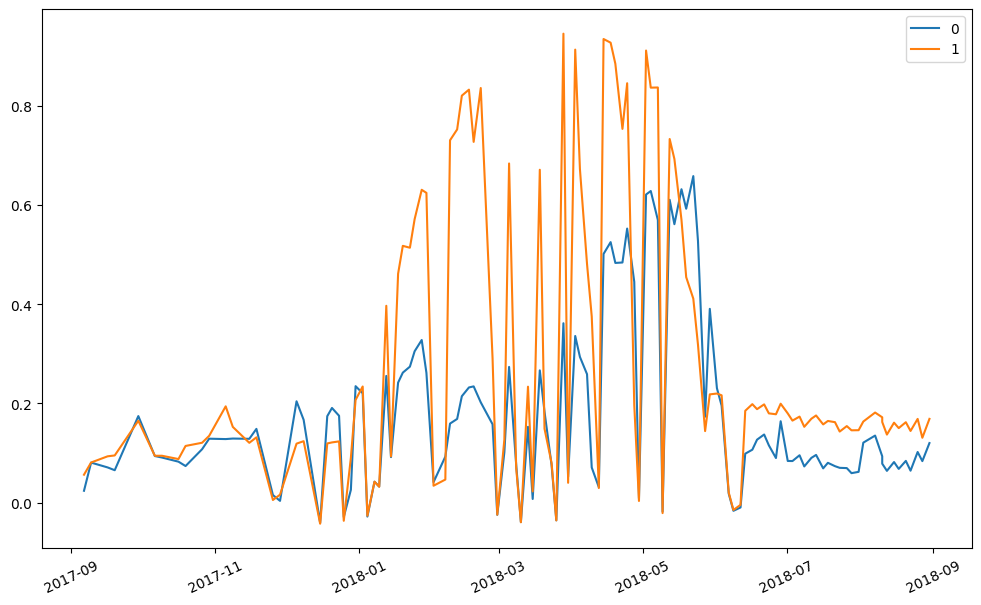

In [10]:
import os
import time
import math
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as dt
from datetime import datetime as dateTim

# Load shapefile
from geetools import batch

# Show time series like earth engine
from ipygee import *
import json

#Leemos un shapeFile alojado en nuetro espacio en Google Drive
path_file = os.path.join('/content/drive/MyDrive/Colab Notebooks/HIBA/Cuadernos Colab/4 - Graficando resultados/datos/parcelas_grafico.shp')
tabla = geemap.shp_to_ee(path_file)


#Definimos las fechas de inicio y fin de la colección
start_date='2017-09-01'
end_date='2018-09-01'

#Creamos una colección de imágenes
coleccion = ee.ImageCollection('COPERNICUS/S2_SR').filterBounds(tabla)\
          .filterDate(start_date, end_date)

#Calculamos el índice NDVI a cada una de las imágenes de la colección
coleccion=coleccion.map(NDVI)
#print ("Numero de imágenes en la colección: ",coleccion.size().getInfo())

print ("Numero de imágenes: ",coleccion.size().getInfo())

escala=10
banda = 'NDVI'

grafico = chart.Image.seriesByRegion(**{
      'imageCollection': coleccion,
      'regions': tabla,
      'reducer': ee.Reducer.mean(),
      'scale': escala,
      'band': banda
})

formatter = dt.DateFormatter('%Y-%m-%d')  # Specify the format - %b gives us Jan, Feb...
locator = dt.MonthLocator()  # every month

df=grafico.dataframe

dates = df.index.values
indexes = df.columns
index_count = 0
index_total = len(indexes)

plt.figure(figsize=(12,7))

for i in range(index_total):
  index = indexes[i]
  data=df[index]
  plt.plot(dates,data,label=index)
  plt.xticks(rotation=25)
  plt.grid()
  plt.legend()



Este script es lo mismo que el anterior, salvo que a la hora de crear la colección de imágenes se ha tenido en cuenta para la propiedad `CLOUD_COVERAGE_ASSESSMENT` un porcentaje inferior al 10%.

Comparar las gráficas.

Numero de imágenes:  58


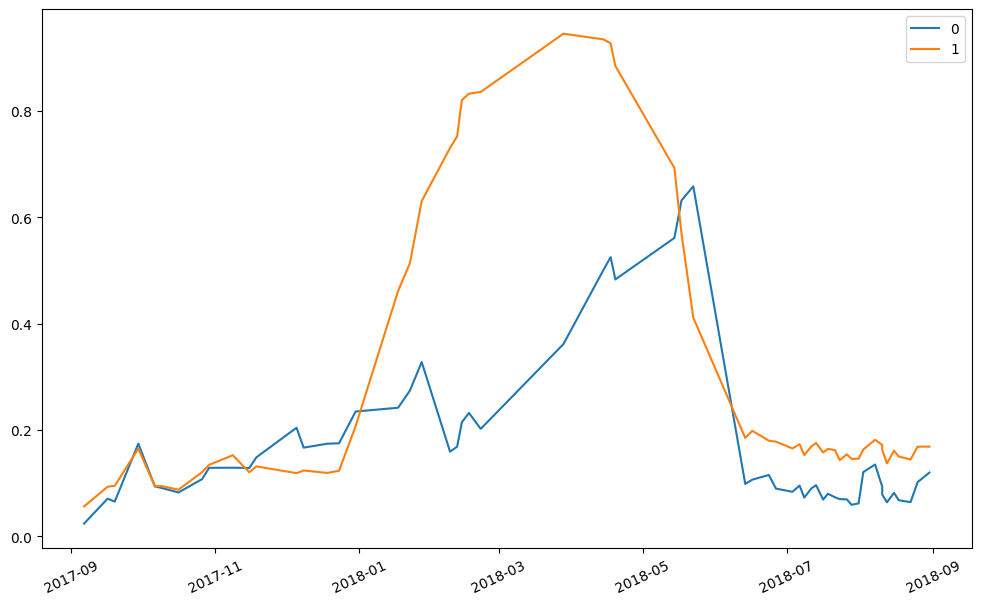

In [12]:
import os
import time
import math
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as dt
from datetime import datetime as dateTim

# Load shapefile
from geetools import batch

# Show time series like earth engine
from ipygee import *
import json

#Leemos un shapeFile alojado en nuetro espacio en Google Drive
path_file = os.path.join('/content/drive/MyDrive/Colab Notebooks/HIBA/Cuadernos Colab/4 - Graficando resultados/datos/parcelas_grafico.shp')
tabla = geemap.shp_to_ee(path_file)

#Definimos las fechas de inicio y fin de la colección
start_date='2017-09-01'
end_date='2018-09-01'

#Creamos una colección de imágenes
coleccion = ee.ImageCollection('COPERNICUS/S2_SR').filterBounds(tabla)\
          .filterDate(start_date, end_date)\
          .filterMetadata('CLOUD_COVERAGE_ASSESSMENT','less_than',10)

#Calculamos el índice NDVI a cada una de las imágenes de la colección
coleccion=coleccion.map(NDVI)
#print ("Numero de imágenes en la colección: ",coleccion.size().getInfo())

print ("Numero de imágenes: ",coleccion.size().getInfo())

escala=10
banda = 'NDVI'

grafico = chart.Image.seriesByRegion(**{
      'imageCollection': coleccion,
      'regions': tabla,
      'reducer': ee.Reducer.mean(),
      'scale': escala,
      'band': banda
})

formatter = dt.DateFormatter('%Y-%m-%d')  # Specify the format - %b gives us Jan, Feb...
locator = dt.MonthLocator()  # every month

df=grafico.dataframe

dates = df.index.values
indexes = df.columns
index_count = 0
index_total = len(indexes)

plt.figure(figsize=(12,7))

for i in range(index_total):
  index = indexes[i]
  data=df[index]
  plt.plot(dates,data,label=index)
  plt.xticks(rotation=25)
  plt.grid()
  plt.legend()

Una vez que tenemos la gráfica almacenada en una variable de tipo dataframe podemos imprimirla en la consola. 



In [13]:
print (df)

                                0         1
2017-09-06 11:01:39.548  0.023771  0.056176
2017-09-16 11:05:23.550  0.070877  0.093278
2017-09-19 11:18:08.254  0.065250  0.095043
2017-09-29 11:16:02.827  0.174431  0.165033
2017-10-06 10:59:37.456  0.093840  0.094356
2017-10-09 11:15:00.339  0.090835  0.094417
2017-10-16 11:03:13.200  0.082475  0.087738
2017-10-26 11:07:17.194  0.107562  0.120637
2017-10-29 11:11:56.456  0.128821  0.134567
2017-11-08 11:20:28.646  0.129082  0.152586
2017-11-15 11:06:20.850  0.128586  0.120498
2017-11-18 11:16:33.239  0.148634  0.131570
2017-12-05 11:04:26.462  0.204267  0.118828
2017-12-08 11:19:44.121  0.166868  0.123817
2017-12-18 11:14:49.458  0.174216  0.119227
2017-12-23 11:14:45.459  0.175043  0.123382
2017-12-30 11:09:35.293  0.234762  0.207014
2018-01-17 11:14:03.462  0.241914  0.461539
2018-01-22 11:13:42.456  0.274118  0.513962
2018-01-27 11:13:22.460  0.327869  0.630796
2018-02-08 11:02:11.458  0.159290  0.730687
2018-02-11 11:18:27.098  0.16869

O almacenarla en un archivo en formato csv en una unidad local.

In [14]:
df.to_csv('/content/drive/My Drive/prueba.csv')